# 🔍 Predicting Item Prices from Descriptions (Part 1)
A complete pipeline from raw text to fine-tuned frontier models

In this project, we aim to **predict item prices based solely on their textual descriptions**. We approach the problem with a structured 3-part pipeline:

- 🧩 **Part 1: Data Curation & Preprocessing** : We aggregate, clean, analyze, and balance the dataset — then export it in .pkl format for the next step: model training and evaluation. ➡️ This is the current notebook you're in.

- ⚔️ **Part 2: Model Benchmarking – Traditional ML vs Frontier LLMs** : We compare traditional machine learning models (SVR, LR, XGBoost) using vectorized text inputs (BoW, Word2Vec) against powerful open and closed-source LLMs (GPT, Claude, LLaMA, ...). 
❗ Who will predict better: handcrafted features or massive pretraining? The results might surprise you.

- 🔧 **Part 3: Fine-Tuning GPT-4o Mini** : We fine-tune GPT-4o Mini on our curated dataset and compare performance before and after.
🤖 Can a fine-tuned GPT-4o Mini beat its own zero-shot performance?

Let’s begin with Part 1.

# 🧩 **Part 1: Data Curation & Preprocessing**

- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 🔑 Hugging Face Token

In [1]:
# imports

import os, sys, random, pickle, importlib
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import Dataset, DatasetDict
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# environment

load_dotenv(override=True)
hf_token = os.getenv('HF_TOKEN')
if not hf_token: print("❌ HF_TOKEN is missing")
    
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# ⚙️ Data Loading & Curation (Simultaneously)
We load and curate the data at the same time using loaders.py and items.py.
- Datasets come from: https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories
- `loaders.py` handles parallel loading and filtering of products
- `items.py` defines the Item class to clean, validate, and prepare each datapoint (title, description, price...) for modeling.


🛠️ Note: Data is filtered to include items priced between 1 and 999 USD.

💡 Comments have been added in both files to clarify the processing logic.

⚠️ Loading 2.8M+ items can take 40+ mins on a regular laptop.

⚠️ Set WORKER wisely in `loaders.py` to match your system capacity. Too many may crash your machine.

In [3]:
sys.path.append('./helpers')
import helpers.items
import helpers.loaders

importlib.reload(helpers.items)
importlib.reload(helpers.loaders)

from helpers.items import Item
from helpers.loaders import ItemLoader

In [4]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [5]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, the larger datasets first... it speeds up the process.

Loading dataset Automotive


100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [28:07<00:00,  1.19it/s]


Completed Automotive with 911,688 datapoints in 28.3 mins
Loading dataset Electronics


100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [19:02<00:00,  1.41it/s]


Completed Electronics with 443,473 datapoints in 19.2 mins
Loading dataset Office_Products


100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [06:37<00:00,  1.79it/s]


Completed Office_Products with 240,394 datapoints in 6.7 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████████████████████████████████████████████████████████████████████████| 1474/1474 [23:31<00:00,  1.04it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 23.7 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [11:54<00:00,  1.81it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 12.0 mins
Loading dataset Toys_and_Games


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [10:27<00:00,  1.42it/s]


Completed Toys_and_Games with 340,479 datapoints in 10.6 mins
Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:05<00:00,  1.45it/s]


Completed Appliances with 28,625 datapoints in 1.1 mins
Loading dataset Musical_Instruments


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:04<00:00,  1.72it/s]


Completed Musical_Instruments with 66,829 datapoints in 2.1 mins


# 🔍 Inspecting a Sample Datapoint

In [6]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


In [7]:
# Investigate the first item from the list

datapoint = items[0]

# Access various attributes
title = datapoint.title
details = datapoint.details
price = datapoint.price
category = datapoint.category

print(f"Datapoint: {datapoint}")
print('*' * 40)
print(f"Title: {title}")
print('*' * 40)
print(f"Detail: {details}")
print('*' * 40)
print(f"Price: ${price}")
print('*' * 40)
print(f"Category: {category}")


Datapoint: <OkuTech Black Retractable Cargo Cover Rear Cargo Privacy Screen Car Trunk Luggage Security Shade Shield for Dodge Journey 5 Seat 2009-2020 = $139.99>
****************************************
Title: OkuTech Black Retractable Cargo Cover Rear Cargo Privacy Screen Car Trunk Luggage Security Shade Shield for Dodge Journey 5 Seat 2009-2020
****************************************
Detail: {"Manufacturer": "Okutech", "Brand": "OkuTech", "Manufacturer Part Number": "OKUTSHED-T114", "Special Features": "Lightweight,Adjustable,Durable", "Best Sellers Rank": {"Automotive": 500770, "Trunk Organizers": 790}, "Date First Available": "December 2, 2021", "Specific Uses For Product": "Car", "Material": "Plastic", "Special Feature": "Lightweight,Adjustable,Durable", "Number of Items": "1"}
****************************************
Price: $139.99
****************************************
Category: Automotive


In [8]:
# The prompt that will be used during training
print(items[0].prompt)
print('*' * 40)
# The prompt that will be used during testing
print(items[0].test_prompt())

How much does this cost to the nearest dollar?

OkuTech Black Retractable Cargo Cover Rear Cargo Privacy Screen Car Trunk Luggage Security Shade Shield for Dodge Journey 5 Seat
Product Details Fits Car Model Dodge Journey 5 Seat Product Name Retractable Cargo Cover Material Aluminum alloy&Canvas Highlights & Features 1. Bar part is Made of Aluminum (Strengthen the main bar). 2. Designed open handle, Easy to handle and remove. Strengthen springs in both retract ends. Direct snap-on designed for easy installation. Installs in seconds! No Drilling needed. 3. Perfect matching with original slot. Raised squre on the ends and flocked fabric covered the retract ends and let you keep away it form annoying noise. No scratches or wear marks. 4. Surface Finish Designed from the best top quality material

Price is $140.00
****************************************
How much does this cost to the nearest dollar?

OkuTech Black Retractable Cargo Cover Rear Cargo Privacy Screen Car Trunk Luggage Securit

# 📊 Data Visualization

In [9]:
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

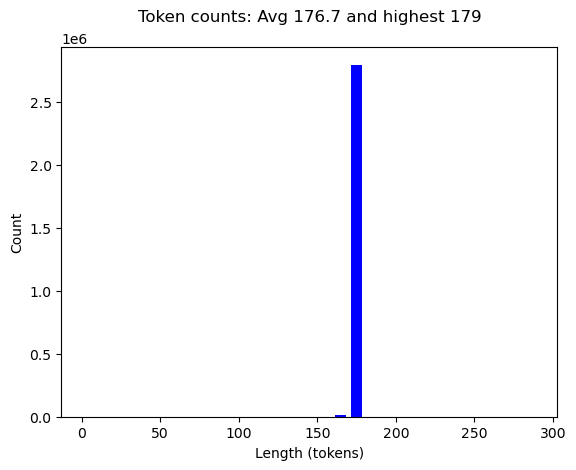

In [10]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="blue", bins=range(0, 300, 10))
plt.show()

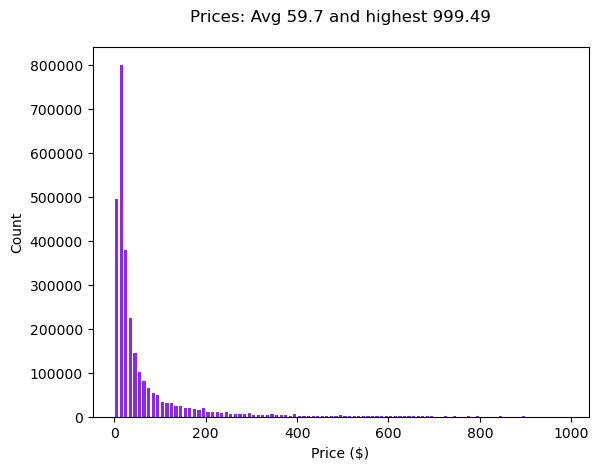

In [11]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

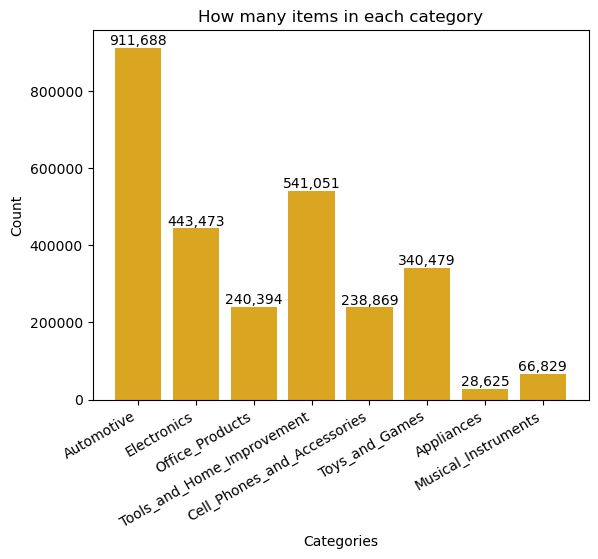

In [12]:
# Plot the distribution of categories

category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.bar(categories, counts, color="goldenrod")
plt.title('How many items in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# 🎯 Data Sampling

We sample to keep the dataset balanced but rich:
- 🎯 Keep all items if price ≥ $240 or group size ≤ 1200
- 🎯 For large groups, randomly sample 1200 items, favoring rare categories

✅ This keeps valuable high-price items and avoids overrepresented classes

In [13]:
HEAVY_DATASET = "Automative"

# Group items by rounded price
# Slots is a dictionary where the keys are rounded prices and the values are lists of items that have that rounded price
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

np.random.seed(42) # Set random seed for reproducibility
sample = [] # Final collection of items after our sampling process completes

# Sampling loop
for price, items_at_price in slots.items():
    
    # Take all items if price ≥ 240 or small group
    if price >= 240 or len(items_at_price) <= 1200:
        sample.extend(items_at_price)
    
    # Otherwise sample 1200 items with weights
    else:
        
        # Weight: 1 for toys, 5 for others
        weights = [1 if item.category == HEAVY_DATASET else 5 for item in items_at_price]
        weights = np.array(weights) / sum(weights)
        
        indices = np.random.choice(len(items_at_price), 1200, False, weights) # False = don't pick the same index twice
        sample.extend([items_at_price[i] for i in indices])

print(f"There are {len(sample):,} items in the sample")

There are 409,172 items in the sample


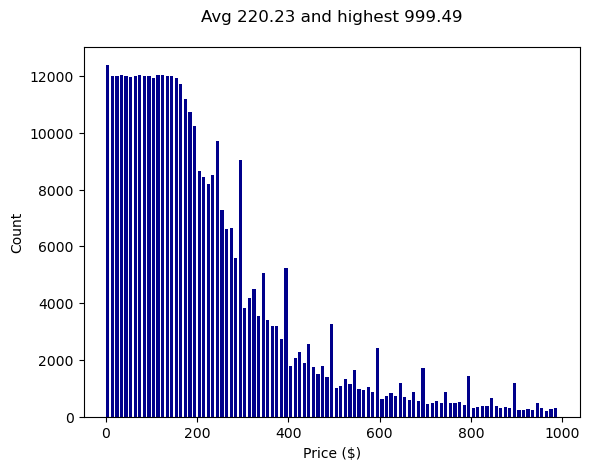

In [14]:
# Plot the distribution of prices in the sample

prices = [float(item.price) for item in sample]
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

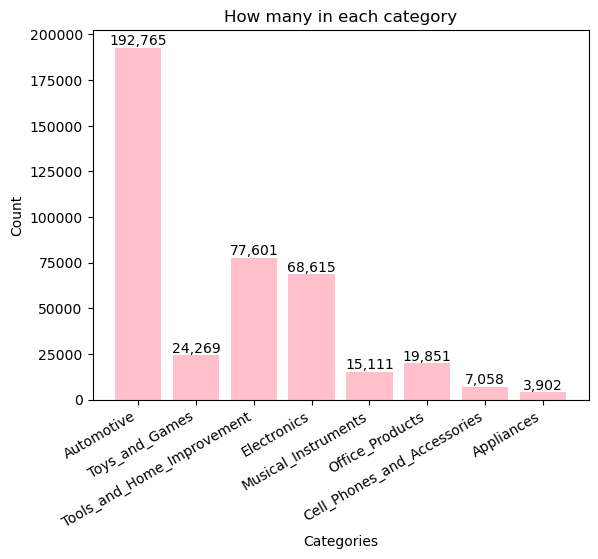

In [15]:
# Plot the distribution of categories in the sample

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.bar(categories, counts, color="pink")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

The HEAVY_DATASET still in the lead, but improved somewhat

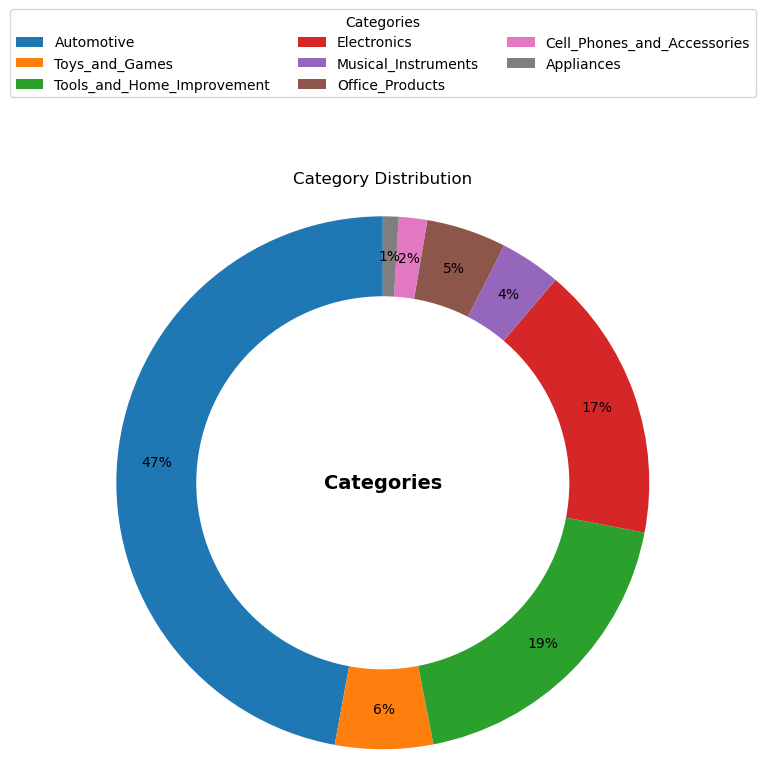

In [16]:
# Create pie chart

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    # labels=categories,
    autopct='%1.0f%%',
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.1
)
ax.legend(wedges, categories, title="Categories", loc="lower center", bbox_to_anchor=(0.5, 1.15), ncol=3)

# Draw donut center
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add center label
ax.text(0, 0, "Categories", ha='center', va='center', fontsize=14, fontweight='bold')

# Equal aspect ratio
plt.axis('equal')
plt.title("Category Distribution")
plt.tight_layout()
plt.show()


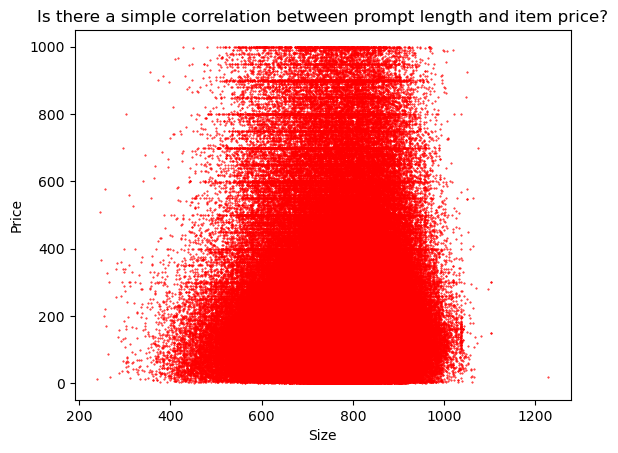

In [17]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation between prompt length and item price?')

# Display the plot
plt.show()

There is no strong or simple correlation between prompt length and item price.

In other words, longer prompts don’t clearly mean higher prices, and vice versa.

# ✅ Final Check Before Training

In [18]:
# Ensure the price label is correctly placed by the end of the prompt

def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-6:])
    print(Item.tokenizer.batch_decode(tokens[-6:]))

report(sample[50])

How much does this cost to the nearest dollar?

Elkay Bottom Grid, Small, Stainless Steel
Elkay sink accessories are designed to fit perfectly and coordinate with your Elkay sink. From color matched drains to custom-sized stainless steel sink grids and wood cutting boards, we have what you need. Our accessories make the time at your kitchen, prep, bar or laundry sink more convenient, efficient and effortless. DIMENSIONS 19 x 17 x 1 CUSTOM SIZED Designed to cover the bottom of specific Elkay sink bowls. CORROSION RESISTANT Constructed of solid stainless steel to resist corrosion. PROTECTS SINK BOTTOM Specially designed feet protect sink bottom to keep it looking great. BEFORE YOU MAKE YOUR PURCHASE Please view images for measuring instructions and dimensions. Brand Elkay, Color Stainless Steel, Material Stainless Steel,

Price is $140.00
[7117, 374, 400, 6860, 13, 410]
['Price', ' is', ' $', '140', '.', '00']


LLaMA and GPT-4o both tokenize numbers from 1 to 999 as a single token, while models like Qwen2, Gemma, and Phi-3 split them into multiple tokens. This helps keep prices compact in our prompts — useful for our project, though not strictly required.

# 📦 Creating Train/Test Datasets

In [19]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [20]:
print(train[0].prompt)
print('*' * 40)
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Detail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon
The TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new

Price is $130.00
****************************************
How much does this cost to the nearest dollar?

Solera Slide Topper Slide-Out Protection for RVs, Travel Trailers, 5th Wheels, and Motorhomes
Tired of dirt, leaves 

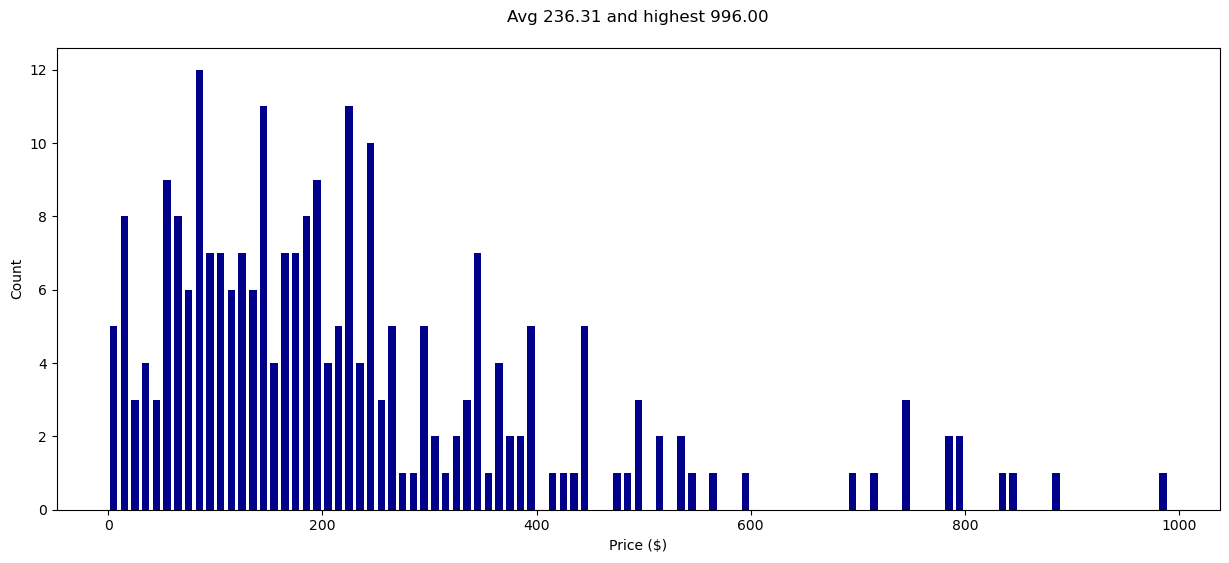

In [21]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [22]:
#  Extract prompts and prices
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

# Create Hugging Face datasets
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Save full Item objects
os.makedirs("data", exist_ok=True) # Make sure the folder exists

# Save full Item objects to the folder
with open('data/train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('data/test.pkl', 'wb') as file:
    pickle.dump(test, file)

In [23]:
# Push to the Hugging Face Hub
USERNAME = "Lizk75"  # 🔧 Replace with your Hugging Face username
DATASET_NAME = f"{USERNAME}/pricer-data"

dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Lizk75/pricer-data/commit/9523ab23d693d799651f67fdadca8d5956d75372', commit_message='Upload dataset', commit_description='', oid='9523ab23d693d799651f67fdadca8d5956d75372', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Lizk75/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Lizk75/pricer-data'), pr_revision=None, pr_num=None)

**Note:** 
- The dataset `pricer-data` on Hugging Face only contains `text` and `price`:


{
  "text": "How much does this cost...Price is $175.00",
  "price": 175.0
}

- Full `Item` objects (with metadata) are available in `train.pkl` and `test.pkl`:

Item(data={
    "title": str,
    "description": list[str],
    "features": list[str],
    "details": str
}, price=float)


Now, it’s time to move on to **Part 2: Model Benchmarking – Traditional ML vs Frontier LLMs.**

🔜 See you in the next notebook.